
 List of plagiarized documents for the training file with 100 docs, shingle parameter K has been set to 3 

     ID1    ID2   JSValue Plagiarism
0   t980  t2023  0.992583        Yes
1  t1088  t5015  0.992081        Yes
2  t1297  t4638  0.992117        Yes
3  t1768  t5248  0.991794        Yes
4  t1952  t3495  0.992405        Yes


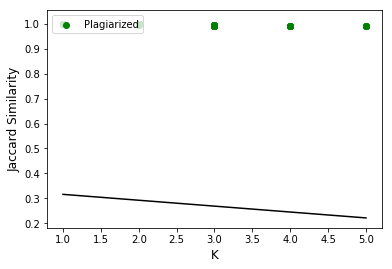

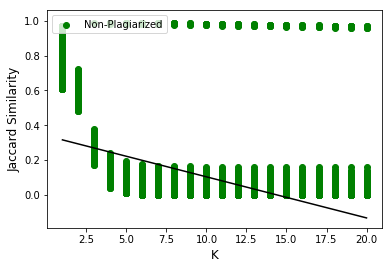

In [23]:
import string
import binascii
import pandas as pd
from sklearn import linear_model                            
from matplotlib import pyplot as plt

#--------------------------------------------------------------------------------------
# Part 1A Dataset parsing
#-------------------------------------------------------------------------------------- 
def parse_data(testfile):
    final_list = []
    fd = open(testfile,"r")                                  # opening file in read mode
    for line in fd:
        ids = []
        text = []
        tup = ()
        a = line.split()                                    # getting the contents of the first line in the document
        ids.append(a[0])                                    # extracting the document ID
        idtup = tuple(ids)
        del a[0]
        article = ''
        for word in a:
            word = word.lower()                             # converting to lower case
            word = word.translate(str.maketrans('','',string.punctuation)) # removing all punctuations
            article = article + word                        # creating a concatenated string of all the words in the article
        text.append(article)
        articletup = tuple(text)
        tup = idtup + articletup
        final_list.append(tup)
    return tuple(final_list)
#--------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------
# Part 1B Creating Document Shingles
#-------------------------------------------------------------------------------------- 
def shingle_document(t,k):
    docAsShingles = {}
    for i in t:
        docID = i[0]                                        # Extracting the document ID
        s = i[1]                                            # The article text
        shinglesInArticle = set()
        for j in range(0,len(s)-k+1):                       # looping through each character
            shingle = ''
            for m in range(j,j+k):                          # Loop to create shingles
                shingle = shingle + s[m]
            crc = binascii.crc32(shingle.encode()) & 0xffffffff  # To get the 32-bit hashed integer
            shinglesInArticle.add(crc)                      # Adding the shingles to a set
        docAsShingles[docID] = shinglesInArticle            # Storing values in a dict object
    return docAsShingles
#--------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------
# Part 1C Computing Jaccard Similarity
#-------------------------------------------------------------------------------------- 
def jaccard(l):
    flist = []
    k = l.items()                                           # To extract shingle and docIDs
    id = [x for x,_ in k]                                   # Extracting the document IDs through a list comprehension
    for i in range(0,len(id)):
        id1 = tuple([id[i]])                                # Extracting 1st DocID, converting to a list, then to a tuple
        s1 = l[id[i]]
        for j in range(i+1,len(id)):
            m = []
            tup = ()
            id2 = tuple([id[j]])
            s2 = l[id[j]]
            js = (len(s1 & s2)/len(s1 | s2))                # Computing Jaccard Similarity
            if js > 0.99:
                plagiarism = ['Yes']                        # Setting Plagiarism Flag to Yes if JS value>0.99
            else:
                plagiarism = ['No']
            m.append(js)
            tup = id1 + id2 + tuple(m) + tuple(plagiarism)
            flist.append(tup)
    return tuple(flist)
#--------------------------------------------------------------------------------------
            
#--------------------------------------------------------------------------------------
# Testing the code for the 100 train file, with shingle parameter k=3
#--------------------------------------------------------------------------------------
testfile = r'C:\Vidit\PhD\Fall 2018\CMSC 643 - Hector\Project 1\TestFile100.txt'
t = parse_data(testfile)
l = shingle_document(t,3)
j = jaccard(l)
result = []
df = pd.DataFrame(list(j), columns=['ID1', 'ID2', 'JSValue','Plagiarism'])
for row in df.itertuples():
    if row[4] == 'Yes':              # Extracting just the plagiarized documents in 100 train file
        result.append(row[1:])
print("\n List of plagiarized documents for the training file with 100 docs, shingle parameter K has been set to 3 \n")
rf = pd.DataFrame(result, columns=['ID1', 'ID2', 'JSValue','Plagiarism'])
print (rf)   # On matching with the 100 truth file, we have correctly identified all the highly similar document pairs
#--------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------
# Main program with the input as the 1000 train file
# Parameter 'k' varies between 1 and 20
# Parts 1D and 1E
#--------------------------------------------------------------------------------------        
testfile = r'C:\Vidit\PhD\Fall 2018\CMSC 643 - Hector\Project 1\TestFile1000.txt'
t = parse_data(testfile)
plagiarized = []
non_plagiarized = []
for k in range(1,21):
    l = shingle_document(t,k)
    j = jaccard(l)
    df = pd.DataFrame(list(j), columns=['ID1', 'ID2', 'JSValue','Plagiarism'])  # Master DataFrame for 1000 train file
    df['K'] = (k)
    for row in df.itertuples():
        if row[4] == 'Yes':                             
            plagiarized.append(row[1:])                               # Creating a datasource for all plagiarized entries
        else:
            non_plagiarized.append(row[1:])                           # Creating a datasource for all non-plagiarized entries
#print (df)

# Code to answer the Part 1E: Experiment 0
plag_jsvalue = [x for _,_,x,_,_ in plagiarized]                       # Extracting the similarity values for plagiarized
plag_kvalue = [x for _,_,_,_,x in plagiarized]                        # Extracting the k values for plagiarized
non_plag_jsvalue = [x for _,_,x,_,_ in non_plagiarized]               # Extracting the similarity values for non-plagiarized
non_plag_kvalue = [x for _,_,_,_,x in non_plagiarized]                # Extracting the k values for non-plagiarized
dvplag = pd.DataFrame(plag_jsvalue, columns=['JSValue'])
ivplag = pd.DataFrame(plag_kvalue, columns=['K'])
dvnonplag = pd.DataFrame(non_plag_jsvalue, columns=['JSValue'])
ivnonplag = pd.DataFrame(non_plag_kvalue, columns=['K'])
yplag = dvplag['JSValue']
xplag = ivplag
ynon_plag = dvnonplag['JSValue']
xnon_plag = ivnonplag
lm = linear_model.LinearRegression()                                  # Creating a linear regression object
model_plagiarized = lm.fit(xplag,yplag)                               # Fitting a linear model for plagiarized documents
model_non_plagiarized = lm.fit(xnon_plag,ynon_plag)                   # Fitting a linear model for non-plagiarized documents

plt.scatter(xplag, yplag,color='g',label='Plagiarized')               # Graph for plagiarized documents
plt.plot(xplag, lm.predict(xplag),color='k')
plt.legend(loc='upper left')
plt.ylabel('Jaccard Similarity', fontsize=12)
plt.xlabel('K', fontsize=12)
plt.show()

plt.scatter(xnon_plag, ynon_plag,color='g',label='Non-Plagiarized')   # Graph for non-plagiarized documents
plt.plot(xnon_plag, lm.predict(xnon_plag),color='k')
plt.legend(loc='upper left')
plt.ylabel('Jaccard Similarity', fontsize=12)
plt.xlabel('K', fontsize=12)
plt.show()
